# Stock Market Share Price Predictor

## Importing relevant libraries

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

### Loading Data

- ticker: The stock we intend to predict, e.g Tesla would be TSLA.
- n_steps: The timeframe we intend to use for training, e.g. 50 would use the last 50 days' prices.
- scale: Boolean which indicates whether we are want to scale our share prices between 0 and 1 or not.
- lookup_step: The number of days into the future which we intend to predict for.
- The adjcolse, volume, open, high and low indicators will be used for training

In [15]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

### Model

In [16]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

### Training 

In [17]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

### Directory for saving model 

In [18]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [19]:
### Begin training

In [20]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard,es],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/400
124/124 [==============================] - ETA: 0s - loss: 8.3749e-04 - mean_absolute_error: 0.0197
Epoch 00001: val_loss improved from inf to 0.00022, saving model to results/2020-07-19_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 17s 134ms/step - loss: 8.3749e-04 - mean_absolute_error: 0.0197 - val_loss: 2.2464e-04 - val_mean_absolute_error: 0.0089
Epoch 2/400
124/124 [==============================] - ETA: 0s - loss: 5.4730e-04 - mean_absolute_error: 0.0151
Epoch 00002: val_loss improved from 0.00022 to 0.00017, saving model to results/2020-07-19_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 14s 115ms/step - loss: 5.4730e-04 - mean_absolute_error: 0.0151 - val_loss: 1.7473e-04 - val_mean_absolute_error: 0.0072
Epoch 3/400
124/124 [==============================] - ETA: 0s - loss: 5.3394e-04 - mean_absolute_error: 0.0151
Epoch 00003: val_loss improved f

Epoch 23/400
124/124 [==============================] - ETA: 0s - loss: 1.4492e-04 - mean_absolute_error: 0.0094
Epoch 00023: val_loss did not improve from 0.00002
124/124 [==============================] - 15s 122ms/step - loss: 1.4492e-04 - mean_absolute_error: 0.0094 - val_loss: 3.4392e-05 - val_mean_absolute_error: 0.0060
Epoch 24/400
124/124 [==============================] - ETA: 0s - loss: 1.7546e-04 - mean_absolute_error: 0.0103
Epoch 00024: val_loss did not improve from 0.00002
124/124 [==============================] - 15s 122ms/step - loss: 1.7546e-04 - mean_absolute_error: 0.0103 - val_loss: 6.8466e-05 - val_mean_absolute_error: 0.0067
Epoch 25/400
124/124 [==============================] - ETA: 0s - loss: 1.5842e-04 - mean_absolute_error: 0.0098
Epoch 00025: val_loss did not improve from 0.00002
124/124 [==============================] - 16s 125ms/step - loss: 1.5842e-04 - mean_absolute_error: 0.0098 - val_loss: 2.6602e-05 - val_mean_absolute_error: 0.0037
Epoch 26/400
124

Epoch 48/400
124/124 [==============================] - ETA: 0s - loss: 1.1147e-04 - mean_absolute_error: 0.0083
Epoch 00048: val_loss improved from 0.00002 to 0.00002, saving model to results/2020-07-19_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 15s 119ms/step - loss: 1.1147e-04 - mean_absolute_error: 0.0083 - val_loss: 2.0452e-05 - val_mean_absolute_error: 0.0039
Epoch 49/400
124/124 [==============================] - ETA: 0s - loss: 1.1135e-04 - mean_absolute_error: 0.0086
Epoch 00049: val_loss improved from 0.00002 to 0.00002, saving model to results/2020-07-19_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 18s 147ms/step - loss: 1.1135e-04 - mean_absolute_error: 0.0086 - val_loss: 1.9134e-05 - val_mean_absolute_error: 0.0041
Epoch 50/400
124/124 [==============================] - ETA: 0s - loss: 1.4637e-04 - mean_absolute_error: 0.0098
Epoch 00050: val_loss did

Epoch 73/400
124/124 [==============================] - ETA: 0s - loss: 1.1466e-04 - mean_absolute_error: 0.0085
Epoch 00073: val_loss did not improve from 0.00002
124/124 [==============================] - 15s 124ms/step - loss: 1.1466e-04 - mean_absolute_error: 0.0085 - val_loss: 6.6548e-05 - val_mean_absolute_error: 0.0055
Epoch 74/400
124/124 [==============================] - ETA: 0s - loss: 1.2002e-04 - mean_absolute_error: 0.0091
Epoch 00074: val_loss did not improve from 0.00002
124/124 [==============================] - 16s 133ms/step - loss: 1.2002e-04 - mean_absolute_error: 0.0091 - val_loss: 3.1153e-05 - val_mean_absolute_error: 0.0063
Epoch 75/400
124/124 [==============================] - ETA: 0s - loss: 1.1149e-04 - mean_absolute_error: 0.0088
Epoch 00075: val_loss did not improve from 0.00002
124/124 [==============================] - 19s 154ms/step - loss: 1.1149e-04 - mean_absolute_error: 0.0088 - val_loss: 6.1091e-05 - val_mean_absolute_error: 0.0064
Epoch 76/400
124

Epoch 98/400
124/124 [==============================] - ETA: 0s - loss: 1.0395e-04 - mean_absolute_error: 0.0083
Epoch 00098: val_loss did not improve from 0.00002
124/124 [==============================] - 15s 121ms/step - loss: 1.0395e-04 - mean_absolute_error: 0.0083 - val_loss: 4.5065e-05 - val_mean_absolute_error: 0.0051
Epoch 99/400
124/124 [==============================] - ETA: 0s - loss: 1.0450e-04 - mean_absolute_error: 0.0086
Epoch 00099: val_loss did not improve from 0.00002
124/124 [==============================] - 19s 156ms/step - loss: 1.0450e-04 - mean_absolute_error: 0.0086 - val_loss: 5.5364e-05 - val_mean_absolute_error: 0.0072
Epoch 100/400
124/124 [==============================] - ETA: 0s - loss: 1.0266e-04 - mean_absolute_error: 0.0083
Epoch 00100: val_loss did not improve from 0.00002
124/124 [==============================] - 19s 149ms/step - loss: 1.0266e-04 - mean_absolute_error: 0.0083 - val_loss: 7.1334e-05 - val_mean_absolute_error: 0.0069
Epoch 101/400
1

Epoch 147/400
124/124 [==============================] - ETA: 0s - loss: 9.4411e-05 - mean_absolute_error: 0.0080
Epoch 00147: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 9.4411e-05 - mean_absolute_error: 0.0080 - val_loss: 2.4936e-05 - val_mean_absolute_error: 0.0051
Epoch 148/400
124/124 [==============================] - ETA: 0s - loss: 1.0009e-04 - mean_absolute_error: 0.0082
Epoch 00148: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 1.0009e-04 - mean_absolute_error: 0.0082 - val_loss: 2.7060e-05 - val_mean_absolute_error: 0.0037
Epoch 149/400
124/124 [==============================] - ETA: 0s - loss: 9.6770e-05 - mean_absolute_error: 0.0080
Epoch 00149: val_loss did not improve from 0.00001
124/124 [==============================] - 14s 113ms/step - loss: 9.6770e-05 - mean_absolute_error: 0.0080 - val_loss: 5.0648e-05 - val_mean_absolute_error: 0.0051
Epoch 150/400

Epoch 172/400
124/124 [==============================] - ETA: 0s - loss: 9.2438e-05 - mean_absolute_error: 0.0080
Epoch 00172: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 9.2438e-05 - mean_absolute_error: 0.0080 - val_loss: 1.3715e-05 - val_mean_absolute_error: 0.0024
Epoch 173/400
124/124 [==============================] - ETA: 0s - loss: 9.2421e-05 - mean_absolute_error: 0.0080
Epoch 00173: val_loss improved from 0.00001 to 0.00001, saving model to results/2020-07-19_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 13s 107ms/step - loss: 9.2421e-05 - mean_absolute_error: 0.0080 - val_loss: 1.1493e-05 - val_mean_absolute_error: 0.0024
Epoch 174/400
124/124 [==============================] - ETA: 0s - loss: 8.1429e-05 - mean_absolute_error: 0.0075
Epoch 00174: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 108ms/step - loss: 8.1429e-

Epoch 221/400
124/124 [==============================] - ETA: 0s - loss: 7.7548e-05 - mean_absolute_error: 0.0073
Epoch 00221: val_loss did not improve from 0.00001
124/124 [==============================] - 17s 138ms/step - loss: 7.7548e-05 - mean_absolute_error: 0.0073 - val_loss: 1.8379e-05 - val_mean_absolute_error: 0.0037
Epoch 222/400
124/124 [==============================] - ETA: 0s - loss: 9.3527e-05 - mean_absolute_error: 0.0078
Epoch 00222: val_loss did not improve from 0.00001
124/124 [==============================] - 17s 138ms/step - loss: 9.3527e-05 - mean_absolute_error: 0.0078 - val_loss: 3.0607e-05 - val_mean_absolute_error: 0.0038
Epoch 223/400
124/124 [==============================] - ETA: 0s - loss: 8.9478e-05 - mean_absolute_error: 0.0076
Epoch 00223: val_loss did not improve from 0.00001
124/124 [==============================] - 17s 135ms/step - loss: 8.9478e-05 - mean_absolute_error: 0.0076 - val_loss: 3.8150e-05 - val_mean_absolute_error: 0.0056
Epoch 224/400

Epoch 246/400
124/124 [==============================] - ETA: 0s - loss: 7.7093e-05 - mean_absolute_error: 0.0072
Epoch 00246: val_loss did not improve from 0.00001
124/124 [==============================] - 28s 223ms/step - loss: 7.7093e-05 - mean_absolute_error: 0.0072 - val_loss: 2.1712e-05 - val_mean_absolute_error: 0.0045
Epoch 247/400
124/124 [==============================] - ETA: 0s - loss: 8.4256e-05 - mean_absolute_error: 0.0072
Epoch 00247: val_loss did not improve from 0.00001
124/124 [==============================] - 25s 202ms/step - loss: 8.4256e-05 - mean_absolute_error: 0.0072 - val_loss: 1.1924e-05 - val_mean_absolute_error: 0.0024
Epoch 248/400
124/124 [==============================] - ETA: 0s - loss: 9.6096e-05 - mean_absolute_error: 0.0079
Epoch 00248: val_loss did not improve from 0.00001
124/124 [==============================] - 26s 208ms/step - loss: 9.6096e-05 - mean_absolute_error: 0.0079 - val_loss: 2.3047e-05 - val_mean_absolute_error: 0.0032
Epoch 249/400

Epoch 271/400
124/124 [==============================] - ETA: 0s - loss: 9.0477e-05 - mean_absolute_error: 0.0078
Epoch 00271: val_loss did not improve from 0.00001
124/124 [==============================] - 16s 130ms/step - loss: 9.0477e-05 - mean_absolute_error: 0.0078 - val_loss: 2.4826e-05 - val_mean_absolute_error: 0.0035
Epoch 272/400
124/124 [==============================] - ETA: 0s - loss: 8.1393e-05 - mean_absolute_error: 0.0072
Epoch 00272: val_loss did not improve from 0.00001
124/124 [==============================] - 19s 153ms/step - loss: 8.1393e-05 - mean_absolute_error: 0.0072 - val_loss: 2.3854e-05 - val_mean_absolute_error: 0.0036
Epoch 273/400
124/124 [==============================] - ETA: 0s - loss: 8.5350e-05 - mean_absolute_error: 0.0076
Epoch 00273: val_loss did not improve from 0.00001
124/124 [==============================] - 18s 146ms/step - loss: 8.5350e-05 - mean_absolute_error: 0.0076 - val_loss: 3.7487e-05 - val_mean_absolute_error: 0.0046
Epoch 274/400

Epoch 296/400
124/124 [==============================] - ETA: 0s - loss: 8.5811e-05 - mean_absolute_error: 0.0075
Epoch 00296: val_loss did not improve from 0.00001
124/124 [==============================] - 17s 140ms/step - loss: 8.5811e-05 - mean_absolute_error: 0.0075 - val_loss: 1.1513e-05 - val_mean_absolute_error: 0.0032
Epoch 297/400
124/124 [==============================] - ETA: 0s - loss: 6.8185e-05 - mean_absolute_error: 0.0069
Epoch 00297: val_loss did not improve from 0.00001
124/124 [==============================] - 17s 141ms/step - loss: 6.8185e-05 - mean_absolute_error: 0.0069 - val_loss: 1.2410e-05 - val_mean_absolute_error: 0.0027
Epoch 298/400
124/124 [==============================] - ETA: 0s - loss: 7.5957e-05 - mean_absolute_error: 0.0070
Epoch 00298: val_loss did not improve from 0.00001
124/124 [==============================] - 15s 119ms/step - loss: 7.5957e-05 - mean_absolute_error: 0.0070 - val_loss: 1.1797e-05 - val_mean_absolute_error: 0.0024
Epoch 299/400

Epoch 321/400
124/124 [==============================] - ETA: 0s - loss: 7.2339e-05 - mean_absolute_error: 0.0069
Epoch 00321: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 106ms/step - loss: 7.2339e-05 - mean_absolute_error: 0.0069 - val_loss: 2.5370e-05 - val_mean_absolute_error: 0.0038
Epoch 322/400
124/124 [==============================] - ETA: 0s - loss: 7.9647e-05 - mean_absolute_error: 0.0071
Epoch 00322: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.9647e-05 - mean_absolute_error: 0.0071 - val_loss: 1.6229e-05 - val_mean_absolute_error: 0.0036
Epoch 323/400
124/124 [==============================] - ETA: 0s - loss: 7.5943e-05 - mean_absolute_error: 0.0071
Epoch 00323: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.5943e-05 - mean_absolute_error: 0.0071 - val_loss: 5.1140e-05 - val_mean_absolute_error: 0.0072
Epoch 324/400

Epoch 346/400
124/124 [==============================] - ETA: 0s - loss: 7.0049e-05 - mean_absolute_error: 0.0070
Epoch 00346: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.0049e-05 - mean_absolute_error: 0.0070 - val_loss: 1.4244e-05 - val_mean_absolute_error: 0.0027
Epoch 347/400
124/124 [==============================] - ETA: 0s - loss: 7.6592e-05 - mean_absolute_error: 0.0071
Epoch 00347: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.6592e-05 - mean_absolute_error: 0.0071 - val_loss: 1.3708e-05 - val_mean_absolute_error: 0.0021
Epoch 348/400
124/124 [==============================] - ETA: 0s - loss: 6.9953e-05 - mean_absolute_error: 0.0069
Epoch 00348: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 105ms/step - loss: 6.9953e-05 - mean_absolute_error: 0.0069 - val_loss: 1.3584e-05 - val_mean_absolute_error: 0.0030
Epoch 349/400

Epoch 371/400
124/124 [==============================] - ETA: 0s - loss: 7.3937e-05 - mean_absolute_error: 0.0070
Epoch 00371: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 106ms/step - loss: 7.3937e-05 - mean_absolute_error: 0.0070 - val_loss: 1.3797e-05 - val_mean_absolute_error: 0.0030
Epoch 372/400
124/124 [==============================] - ETA: 0s - loss: 6.7805e-05 - mean_absolute_error: 0.0068
Epoch 00372: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 106ms/step - loss: 6.7805e-05 - mean_absolute_error: 0.0068 - val_loss: 1.3900e-05 - val_mean_absolute_error: 0.0031
Epoch 373/400
124/124 [==============================] - ETA: 0s - loss: 7.6548e-05 - mean_absolute_error: 0.0072
Epoch 00373: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 108ms/step - loss: 7.6548e-05 - mean_absolute_error: 0.0072 - val_loss: 3.6915e-05 - val_mean_absolute_error: 0.0052
Epoch 374/400

Epoch 396/400
124/124 [==============================] - ETA: 0s - loss: 7.1783e-05 - mean_absolute_error: 0.0070
Epoch 00396: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.1783e-05 - mean_absolute_error: 0.0070 - val_loss: 3.6645e-05 - val_mean_absolute_error: 0.0040
Epoch 397/400
124/124 [==============================] - ETA: 0s - loss: 6.6473e-05 - mean_absolute_error: 0.0069
Epoch 00397: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 106ms/step - loss: 6.6473e-05 - mean_absolute_error: 0.0069 - val_loss: 1.1371e-05 - val_mean_absolute_error: 0.0022
Epoch 398/400
124/124 [==============================] - ETA: 0s - loss: 7.1367e-05 - mean_absolute_error: 0.0070- ETA: 2s - loss: 6.9283e-05 - mean
Epoch 00398: val_loss did not improve from 0.00001
124/124 [==============================] - 13s 107ms/step - loss: 7.1367e-05 - mean_absolute_error: 0.0070 - val_loss: 1.6135e-05 - val_mean_a

In [23]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [24]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 2.424268679294879


In [26]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [27]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 398.45$


In [28]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

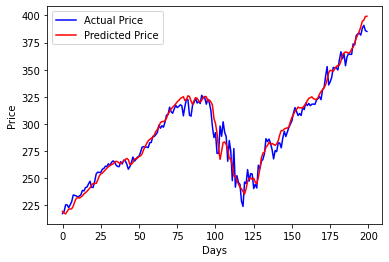

In [29]:
plot_graph(model, data)

# SECTION 2

### Using LSTMs to predict the closing stock price of Apple Inc. (Using past 60 days data)

### Importing relevant libraries

In [1]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Get stock data

In [2]:
# data from 1 Jan 2015 to 01 Aug 2020
df = web.DataReader('AAPL', data_source='yahoo', start = '2015-01-01',end='2020-08-01')
# exploring data
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,111.440002,107.349998,111.389999,109.330002,53204600.0,99.945885
2015-01-05,108.650002,105.410004,108.290001,106.250000,64285500.0,97.130241
2015-01-06,107.430000,104.629997,106.540001,106.260002,65797100.0,97.139420
2015-01-07,108.199997,106.699997,107.199997,107.750000,40105900.0,98.501518
2015-01-08,112.150002,108.699997,109.230003,111.889999,59364500.0,102.286186


In [3]:
df.shape

(1405, 6)

### Visualizing closing price history

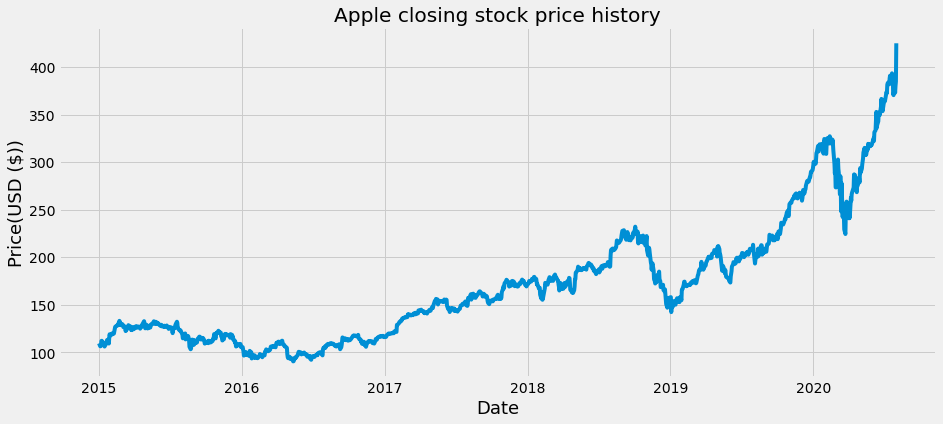

In [4]:
plt.figure(figsize=(14,6))
plt.title('Apple closing stock price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price(USD ($))', fontsize=18)
plt.show()

In [5]:
# select closing price only
data = df.filter(['Close'])
# convert to numpy 
dataset = data.values
# compute number of rows to train model on.
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

1124

### Scaling prices between 0 and 1

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

### Creating Training data

In [7]:
train_data = scaled_data[0:training_data_len, :]
# split data into x_train and y_train
x_train = []
y_train = []

# 0-60 days as features and day 61 as targets
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    # print data for first pass through
    if i<=60:
        print(x_train)
        print(y_train)
        print('\n')

[array([0.05673739, 0.04753512, 0.047565  , 0.05201674, 0.06438602,
       0.06474456, 0.05649837, 0.05939649, 0.05814164, 0.04923813,
       0.04675829, 0.05491486, 0.0573947 , 0.06590978, 0.06764268,
       0.0680012 , 0.05616971, 0.07460412, 0.08533016, 0.08013148,
       0.08452345, 0.08458322, 0.08730206, 0.08843742, 0.08541979,
       0.08778011, 0.09465192, 0.10319689, 0.10791754, 0.10976996,
       0.11201077, 0.11466986, 0.11386316, 0.11700031, 0.12745743,
       0.12497759, 0.11487898, 0.11974903, 0.11389307, 0.11577532,
       0.11658202, 0.11413205, 0.10776817, 0.10833583, 0.10994921,
       0.10209144, 0.09530923, 0.10191216, 0.09934269, 0.10340603,
       0.10965044, 0.11392293, 0.11102481, 0.10624441, 0.11015835,
       0.10860473, 0.09871527, 0.10128473, 0.09832687, 0.10764866])]
[0.10185241327747102]




### Convert data sets to numpy arrays

In [8]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1064, 60)

In [9]:
# reshape x_train since lstm expects 3D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1064, 60, 1)

## Model Construction

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

## Model Compilation

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train Model

In [12]:
history = model.fit(x_train, y_train,
    batch_size=32,
    epochs=100,
    verbose=1,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)],
    )


Epoch 1/100
30/30 [==============================] - 6s 207ms/step - loss: 0.0043 - val_loss: 8.3540e-04
Epoch 2/100
30/30 [==============================] - 4s 146ms/step - loss: 3.7163e-04 - val_loss: 5.6592e-04
Epoch 3/100
30/30 [==============================] - 5s 161ms/step - loss: 2.7709e-04 - val_loss: 5.9802e-04
Epoch 4/100
30/30 [==============================] - 5s 167ms/step - loss: 2.6137e-04 - val_loss: 5.7580e-04
Epoch 5/100
30/30 [==============================] - 5s 162ms/step - loss: 2.5842e-04 - val_loss: 6.0125e-04
Epoch 6/100
30/30 [==============================] - 5s 164ms/step - loss: 2.3348e-04 - val_loss: 4.9914e-04
Epoch 7/100
30/30 [==============================] - 6s 188ms/step - loss: 2.3156e-04 - val_loss: 5.5985e-04
Epoch 8/100
30/30 [==============================] - 5s 163ms/step - loss: 2.1093e-04 - val_loss: 4.2556e-04
Epoch 9/100
30/30 [==============================] - 5s 156ms/step - loss: 2.1277e-04 - val_loss: 4.0044e-04
Epoch 10/100
30/30 [===

30/30 [==============================] - 4s 149ms/step - loss: 7.3785e-05 - val_loss: 1.2381e-04
Epoch 76/100
30/30 [==============================] - 4s 148ms/step - loss: 8.0011e-05 - val_loss: 2.2950e-04
Epoch 77/100
30/30 [==============================] - 4s 145ms/step - loss: 8.2039e-05 - val_loss: 1.4370e-04
Epoch 78/100
30/30 [==============================] - 4s 148ms/step - loss: 7.5708e-05 - val_loss: 1.5812e-04
Epoch 79/100
30/30 [==============================] - 5s 151ms/step - loss: 7.0059e-05 - val_loss: 1.2150e-04
Epoch 80/100
30/30 [==============================] - 4s 144ms/step - loss: 6.4422e-05 - val_loss: 9.5811e-05
Epoch 81/100
30/30 [==============================] - 4s 148ms/step - loss: 7.3146e-05 - val_loss: 9.8694e-05
Epoch 82/100
30/30 [==============================] - 5s 152ms/step - loss: 6.7517e-05 - val_loss: 1.1884e-04
Epoch 83/100
30/30 [==============================] - 5s 155ms/step - loss: 7.3177e-05 - val_loss: 1.1377e-04
Epoch 84/100
30/30 [===

In [13]:
# save model
import os
model.save(os.path.join("results", 'myModel') + ".h5")

## Model Evaluation

dict_keys(['loss', 'val_loss'])


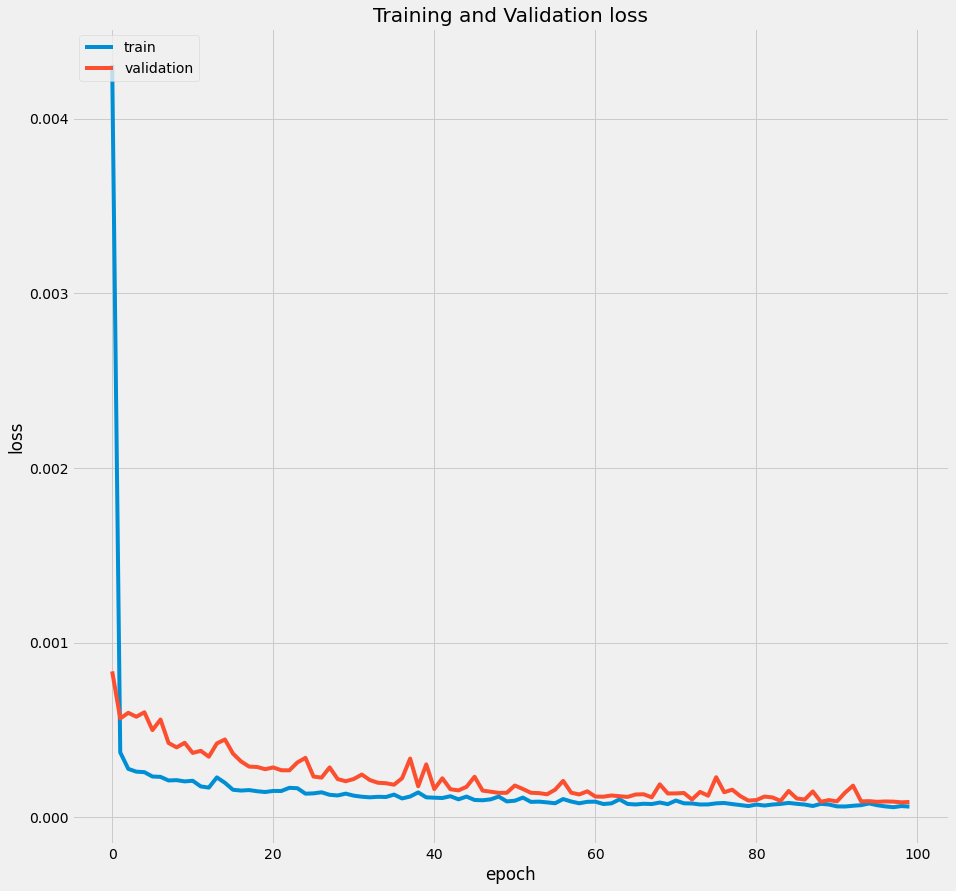

In [21]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(14,14))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Create testing data set

In [33]:
test_data  = scaled_data[training_data_len-60:, :]
# create x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]

# x_test contains the past 60 days' values and y_test contains the 61st day's values
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
# convert to numpy array    
x_test = np.array(x_test)

#reshape data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

x_test.shape

(281, 60, 1)

In [34]:
# get model predicted values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

### Evaluate test results

In [35]:
# find the root means square error(RMSE).
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.676209907939001

## Plot Data

<ipython-input-44-3d0367a2f561>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


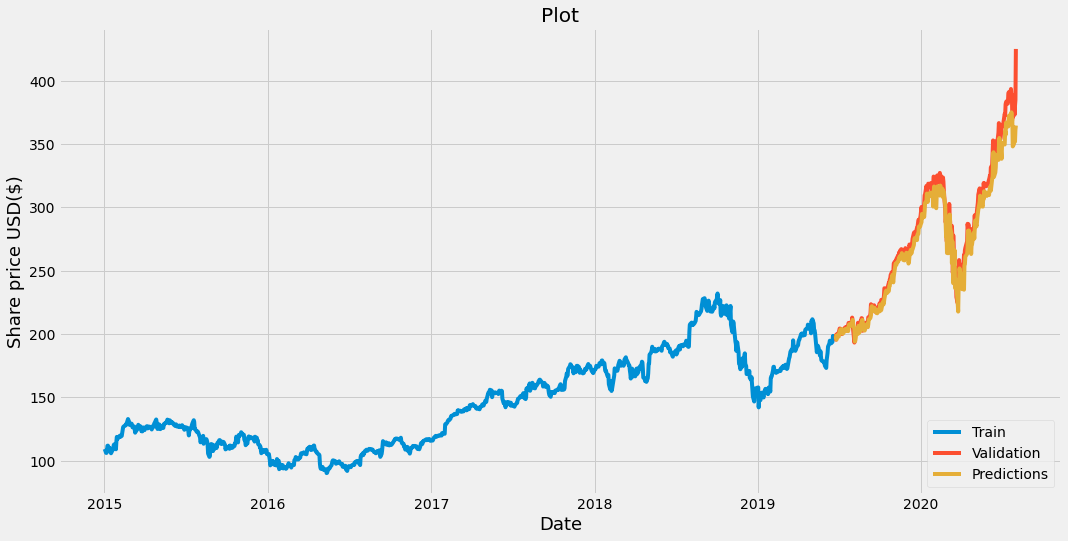

In [44]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

## plot 

plt.figure(figsize=(16,8))
plt.title('Plot')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Share price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Validation','Predictions'], loc='lower right')
plt.show()

In [46]:
# actual values vs predictions
valid

,Close,Predictions
Date,,
2019-06-21,198.779999,198.524872
2019-06-24,198.580002,198.368774
2019-06-25,195.570007,198.100418
2019-06-26,199.800003,195.656982
2019-06-27,199.740005,198.327408
...,...,...
2020-07-27,379.239990,350.234863
2020-07-28,373.010010,359.735535
2020-07-29,380.160004,352.027039


### Predict future price (03 Aug 2020)

In [54]:
# fetch data
apple_quote = web.DataReader('AAPL', data_source='yahoo', start = '2015-01-01',end='2020-08-01')
new_df = apple_quote.filter(['Close'])

# get las 60 days
last_60_days = new_df[-60:].values
#scale data
last_60_days_scaled = scaler.transform(last_60_days)

# empty list
X_test = []

# append last 60 days
X_test.append(last_60_days_scaled)
# convert X_test to numpy array
X_test = np.array(X_test)
# reshape for lstm
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predict

pred_price = model.predict(X_test)
# reverse scaling
pred_price = scaler.inverse_transform(pred_price)
print('The predicted price is :',pred_price)

The predicted price is : [[410.228]]
